In [2]:
import pandas as pd

In [6]:
usecols = ['timestamp', 'text']
dtype_mapping = {
    'timestamp': str,
    'text': str
}

# Wczytaj dane z pliku, ale nie wczytuj wszystkich chunków na raz
data = pd.read_csv('C:\\Users\\wcwik02\\Desktop\\SDA\\PROJEKT_KOŃCOWY\\datasets\\tweets.csv', sep=';', usecols=usecols, dtype=dtype_mapping, chunksize=100000, engine='python', parse_dates=['timestamp'])

# Inicjalizuj pustą listę, która będzie przechowywać filtrowane chunki danych
filtered_data = []

# Iteruj przez chunki danych i wybierz tylko te z odpowiednim zakresem dat
for chunk in data:
    filtered_chunk = chunk[(chunk['timestamp'] >= '2014-09-17') & (chunk['timestamp'] <= '2019-05-27')]
    filtered_data.append(filtered_chunk)

# Po zakończeniu iteracji, połącz wszystkie filtrowane chunki w jedną ramkę danych
df = pd.concat(filtered_data)

In [7]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['Date'] = df['timestamp'].dt.strftime('%Y-%m-%d')
df.drop(['timestamp'], axis=1, inplace=True)
print(df.head())

                                                 text        Date
11  BTC IS STILL GOING STRONG!!\n\nThus, we are gi...  2019-05-21
12  BestMixer has been seized by the Dutch Police ...  2019-05-22
15                                              share  2019-05-10
20  $HOT $HOT $HOT 🍀\n\n🚀🚀🚀🚀🚀\n\n🔥🔥🔥🔥🔥 https://t.c...  2019-05-26
22  https://t.co/Ip0ph8uZYn\n\n#cryptocurrency #dr...  2019-05-02


In [8]:
# Czyszczenie duplikatów
duplicates = df['text'].duplicated()
df = df.drop_duplicates(subset=['text'])
# Czyszczenie pustych wierszy
df.dropna(subset=['text'], inplace=True)

In [9]:
#Wczytanie datasetu z ceną Bitcoina
usecols_bitcoin = ['Date', 'Adj Close']
df_2 = pd.read_csv('C:\\Users\\wcwik02\\Desktop\\SDA\\PROJEKT_KOŃCOWY\\datasets\\BTC-USD.csv', sep =',', usecols=usecols_bitcoin, encoding='utf-8')
df_2.rename(columns={'Adj Close': 'bitcoin_price'}, inplace=True)

In [10]:
def get_trend(df):
    df['bitcoin_trend'] = df['bitcoin_price'].shift(-1) - df['bitcoin_price']
    df['bitcoin_trend'] = df['bitcoin_trend'].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
    return df

In [11]:
#dodanie bitcoin_trend i usunięcie wierszy z wartością 0
get_trend(df_2)
df_2 = df_2[df_2['bitcoin_trend'] != 0]

In [39]:
df.dtypes

text    object
Date    object
dtype: object

In [40]:
df_2.dtypes

Date              object
bitcoin_price    float64
bitcoin_trend      int64
dtype: object

In [12]:
data = df.merge(df_2, on = 'Date', how = 'inner', left_index=False)

In [38]:
data.dtypes

text              object
Date              object
bitcoin_price    float64
bitcoin_trend      int64
dtype: object

In [16]:
start_date = data['Date'].min()
end_date = data['Date'].max()

print(f'start date: {start_date}')
print(f'end date: {end_date}')

start date: 2014-09-17
end date: 2019-05-26


In [14]:
zero_count = data['bitcoin_trend'].eq(0).sum()
one_count = data['bitcoin_trend'].eq(1).sum()
minus_one_count = data['bitcoin_trend'].eq(-1).sum()
print("Liczba wartości 0 w kolumnie 'bitcoin_trend':", zero_count)
print("Liczba wartości 1 kolumnie 'bitcoin_trend':", one_count)
print("Liczba wartości -1 w kolumnie 'bitcoin_trend':", minus_one_count)

Liczba wartości 0 w kolumnie 'bitcoin_trend': 0
Liczba wartości 1 kolumnie 'bitcoin_trend': 2116521
Liczba wartości -1 w kolumnie 'bitcoin_trend': 1816087


In [17]:
import matplotlib.pyplot as plt

In [18]:
def tweets_per_day(data):
    data['Date'] = pd.to_datetime(data['Date']).dt.date

    tweets_count = data.groupby('Date').size()
    plt.figure(figsize=(8, 4))
    plt.plot(tweets_count.index, tweets_count.values, label='Liczba tweetów')
    plt.xlabel('Data')
    plt.ylabel('Liczba tweetów')
    plt.title('Liczba tweetów na dany dzień')
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

In [19]:
def visualize_bitcoin_price(data):
    data['Date'] = pd.to_datetime(data['Date']).dt.date

    plt.figure(figsize=(8, 4))
    plt.plot(data['Date'], data['bitcoin_price'])
    plt.xlabel('Data')
    plt.ylabel('Cena bitcoina')
    plt.title('Zmiana ceny bitcoina w czasie')
    plt.xticks(rotation=45)
    plt.show()

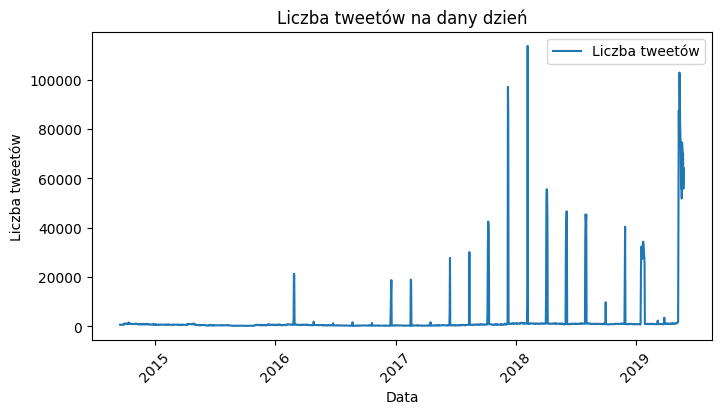

In [20]:
tweets_per_day(data)

In [21]:
def visualize_bitcoin_price_scatter(data):
    data['Date'] = pd.to_datetime(data['Date']).dt.date

    plt.figure(figsize=(8, 4))
    plt.scatter(data['Date'], data['bitcoin_price'])
    plt.xlabel('Data')
    plt.ylabel('Cena bitcoina')
    plt.title('Zmiana ceny bitcoina w czasie')
    plt.xticks(rotation=45)
    plt.show()

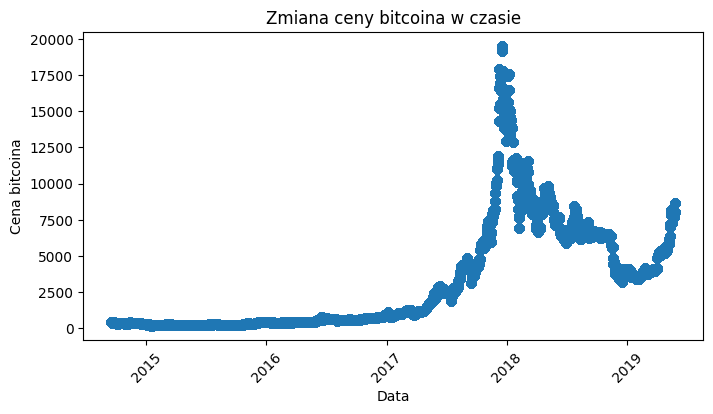

In [22]:
visualize_bitcoin_price_scatter(data)

In [23]:
X = data['text']
y = data['bitcoin_trend']

In [29]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline
import nltk
from sklearn.base import BaseEstimator, TransformerMixin
from nltk.tokenize import word_tokenize

In [27]:
data = data.sort_values('Date')
split_index = int(len(data) * 0.8)

split_date = data.iloc[split_index]['Date']
print("Data dzieląca 80% i 20% danych:", split_date)

Data dzieląca 80% i 20% danych: 2019-05-15


In [28]:
train_data = data[data['Date'] < split_date]
test_data = data[data['Date'] >= split_date]

# Podziel dane treningowe na cechy (X_train) i etykiety (y_train)
X_train = train_data['text']
y_train = train_data['bitcoin_trend']

# Podziel dane testowe na cechy (X_test) i etykiety (y_test)
X_test = test_data['text']
y_test = test_data['bitcoin_trend']

In [ ]:
#from sklearn.model_selection import train_test_split

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(data['text'], data['bitcoin_trend'], test_size=0.2)

In [32]:
# Zamiana na DataFrame
X_train = pd.DataFrame(X_train, columns=['text'])
X_test = pd.DataFrame(X_test, columns=['text'])
y_train = pd.DataFrame(y_train, columns=['bitcoin_trend'])
y_test = pd.DataFrame(y_test, columns=['bitcoin_trend'])

In [33]:
X_train['text']

2796052    $447.00 at 01:00 UTC [24h Range: $443.57 - $46...
2795651    BTCe Prices\nLAST: $444.00\n BID: $444.00\n AS...
2795650    LIVE: Profit = $939.28 (0.55 %). BUY B382.20 @...
2795649    $452.40 at 17:15 UTC [24h Range: $450.00 - $46...
2795648    @KQED, enjoy this little gift! @xeniar sent yo...
                                 ...                        
1204852                                           🔥📈🔥📈🔥📈🔥🙂🚀🌌
1204853    And...immutable in code.\n\nYou prefer the "co...
1204854    Satoshi Website’s Bitcoin Reveal Was Even Stup...
1204845    @Selcoin hocam eth de BTC gibi sert düzeltme y...
1139618    Make sure to update your wallets to the latest...
Name: text, Length: 3121628, dtype: object

In [36]:
X_train.dtypes

text    object
dtype: object

In [41]:
print(X_train.columns)

Index(['text'], dtype='object')


In [42]:
import string

In [43]:
def remove_punctuation(text):
    cleaned = ''.join([word for word in text if word not in string.punctuation])
    return cleaned

In [44]:
class RemovePunctuationTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, text_column):
        self.text_column = text_column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_ = X.copy()
        X_[self.text_column] = X_[self.text_column].apply(lambda x: remove_punctuation(x))
        return X_

In [46]:
removed = RemovePunctuationTransformer('text')
removed.fit_transform(X_train)

,text
2796052,44700 at 0100 UTC 24h Range 44357 46557 Volum...
2795651,BTCe Prices\nLAST 44400\n BID 44400\n ASK 4440...
2795650,LIVE Profit 93928 055 BUY B38220 45019 BTCe...
2795649,45240 at 1715 UTC 24h Range 45000 46940 Volum...
2795648,KQED enjoy this little gift xeniar sent you a ...
...,...
1204852,🔥📈🔥📈🔥📈🔥🙂🚀🌌
1204853,Andimmutable in code\n\nYou prefer the code of...
1204854,Satoshi Website’s Bitcoin Reveal Was Even Stup...
1204845,Selcoin hocam eth de BTC gibi sert düzeltme ya...


In [47]:
def tokenizer(text):
    lower_text = text.lower()
    tokenized_text = nltk.word_tokenize(lower_text)
    return tokenized_text


In [48]:
class TokenizeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, text_column):
        self.text_column = text_column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_ = X.copy()
        X_[self.text_column] = X_[self.text_column].apply(lambda x: tokenizer(x))
        return X_


In [49]:
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')
stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\wcwik02\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [50]:
def remove_stopwords(text):
    without_stopwords = [word for word in text if word not in stopwords]
    return without_stopwords


In [51]:
class RemoveStopwordsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, text_column):
        self.text_column = text_column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_ = X.copy()
        X_[self.text_column] = X_[self.text_column].apply(lambda x: remove_stopwords(x))
        return X_

In [52]:
def remove_short_tokens(text):
    without_shorts = [word for word in text if len(word) > 2]
    return without_shorts


In [53]:
class RemoveShortTokensTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, text_column):
        self.text_column = text_column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_ = X.copy()
        X_[self.text_column] = X_[self.text_column].apply(lambda x: remove_short_tokens(x))
        return X_


In [54]:
from nltk import PorterStemmer

stemmer = PorterStemmer()


In [55]:
def stemming(text):
    stemmed_words = [stemmer.stem(word) for word in text]
    return stemmed_words


In [56]:
class StemTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, text_column):
        self.text_column = text_column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_ = X.copy()
        X_[self.text_column] = X_[self.text_column].apply(lambda x: stemming(x))
        return X_

In [57]:
data['text'].head()

2796052    $447.00 at 01:00 UTC [24h Range: $443.57 - $46...
2795651    BTCe Prices\nLAST: $444.00\n BID: $444.00\n AS...
2795650    LIVE: Profit = $939.28 (0.55 %). BUY B382.20 @...
2795649    $452.40 at 17:15 UTC [24h Range: $450.00 - $46...
2795648    @KQED, enjoy this little gift! @xeniar sent yo...
Name: text, dtype: object

In [59]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3121628 entries, 2796052 to 1139618
Data columns (total 1 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   text    object
dtypes: object(1)
memory usage: 47.6+ MB


In [60]:
#test_pipe_1 = Pipeline(steps=[
#    ('remove_punctuation', RemovePunctuationTransformer(text_column='text')),
#    ('tfidf_vectorizer', TfidfVectorizer()),
#    ('model', LogisticRegression())])

#test_pipe_1.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
#test_pipe_2 = Pipeline(steps=[
#    ('tokenizer', TokenizeTransformer(text_column='text')),
#    ('tfidf_vectorizer', TfidfVectorizer()),
#    ('model', LogisticRegression())])

In [ ]:
#test_pipe_2.fit(X_train)

In [ ]:
#test_pipe_3 = Pipeline(steps=[
#    ('remove_stop_words', RemoveStopwordsTransformer(text_column='text')),
#    ('tfidf_vectorizer', TfidfVectorizer()),
#    ('model', LogisticRegression())])

In [61]:
test_pipe= Pipeline(steps=[
    ('remove_punctuation', RemovePunctuationTransformer(text_column='text')),
    ('tokenizer', TokenizeTransformer(text_column='text')),
    ('remove_stop_words', RemoveStopwordsTransformer(text_column='text')),
    ('remove_short_tokens', RemoveShortTokensTransformer(text_column='text')),
    ('stemmer', StemTransformer(text_column='text')),
    ('tfidf_vectorizer', TfidfVectorizer()),
    ('model', LogisticRegression()),
])

In [63]:
print(data.columns)  # Wyświetlanie nazw kolumn w danych
print(X_train.columns)  # Wyświetlanie nazw kolumn w X_train

# Sprawdzenie, czy kolumna 'text' istnieje w danych
if 'text' in data.columns:
    print("Kolumna 'text' istnieje w danych")
else:
    print("Kolumna 'text' nie istnieje w danych")

# Sprawdzenie, czy kolumna 'text' istnieje w X_train
if 'text' in X_train.columns:
    print("Kolumna 'text' istnieje w X_train")
else:
    print("Kolumna 'text' nie istnieje w X_train")

Index(['text', 'Date', 'bitcoin_price', 'bitcoin_trend'], dtype='object')
Index(['text'], dtype='object')
Kolumna 'text' istnieje w danych
Kolumna 'text' istnieje w X_train


In [62]:
from sklearn.model_selection import GridSearchCV

# Parametry do przetestowania w grid search
parameters = {
    'tfidf_vectorizer__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'tfidf_vectorizer__min_df': [1, 2, 3],
    'tfidf_vectorizer__max_df': [0.5, 0.75, 1.0],
    'model__C': [0.1, 1, 10]
}

# Utworzenie obiektu GridSearchCV
grid_search = GridSearchCV(estimator=test_pipe, param_grid=parameters, cv=5)

# Dopasowanie modelu grid search do danych
grid_search.fit(X_train['text'], y_train['bitcoin_trend'])

# Najlepsze parametry i wynik
print("Najlepsze parametry: ", grid_search.best_params_)
print("Najlepszy wynik: ", grid_search.best_score_)

ValueError: 
All the 405 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
405 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\wcwik02\Desktop\SDA\PROJEKT_KOŃCOWY\venv\lib\site-packages\pandas\core\indexes\base.py", line 3652, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 147, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 155, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index_class_helper.pxi", line 70, in pandas._libs.index.Int64Engine._check_type
KeyError: 'text'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "C:\Users\wcwik02\Desktop\SDA\PROJEKT_KOŃCOWY\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\wcwik02\Desktop\SDA\PROJEKT_KOŃCOWY\venv\lib\site-packages\sklearn\pipeline.py", line 401, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\wcwik02\Desktop\SDA\PROJEKT_KOŃCOWY\venv\lib\site-packages\sklearn\pipeline.py", line 359, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Users\wcwik02\Desktop\SDA\PROJEKT_KOŃCOWY\venv\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\wcwik02\Desktop\SDA\PROJEKT_KOŃCOWY\venv\lib\site-packages\sklearn\pipeline.py", line 893, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "C:\Users\wcwik02\Desktop\SDA\PROJEKT_KOŃCOWY\venv\lib\site-packages\sklearn\utils\_set_output.py", line 140, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "C:\Users\wcwik02\Desktop\SDA\PROJEKT_KOŃCOWY\venv\lib\site-packages\sklearn\base.py", line 881, in fit_transform
    return self.fit(X, y, **fit_params).transform(X)
  File "C:\Users\wcwik02\Desktop\SDA\PROJEKT_KOŃCOWY\venv\lib\site-packages\sklearn\utils\_set_output.py", line 140, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "C:\Users\wcwik02\AppData\Local\Temp\ipykernel_2208\311783383.py", line 10, in transform
    X_[self.text_column] = X_[self.text_column].apply(lambda x: remove_punctuation(x))
  File "C:\Users\wcwik02\Desktop\SDA\PROJEKT_KOŃCOWY\venv\lib\site-packages\pandas\core\series.py", line 1007, in __getitem__
    return self._get_value(key)
  File "C:\Users\wcwik02\Desktop\SDA\PROJEKT_KOŃCOWY\venv\lib\site-packages\pandas\core\series.py", line 1116, in _get_value
    loc = self.index.get_loc(label)
  File "C:\Users\wcwik02\Desktop\SDA\PROJEKT_KOŃCOWY\venv\lib\site-packages\pandas\core\indexes\base.py", line 3654, in get_loc
    raise KeyError(key) from err
KeyError: 'text'


In [65]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\wcwik02\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [ ]:
test_pipe.fit(X_train,y_train)

In [ ]:
test_pipe.prediction(X_test)

In [ ]:
y_pred = pipe_lg.predict(X_test)
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall =recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

In [ ]:
print("Accuracy: {:.2f}".format(accuracy))
print("Precision: {:.2f}".format(precision))
print('Recall:{:.2f'.format(recall))
print("F1: {:.2f}".format(f1))